<a href="https://colab.research.google.com/github/elysekadokura/talking_data_fraud_detection/blob/master/Copy_of_talking_data_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os

In [0]:
#connecting to kaggle and importing datasets
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c talkingdata-adtracking-fraud-detection
!unzip train_sample.csv.zip

mv: cannot stat 'kaggle.json': No such file or directory
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_sample.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_supplement.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train_sample.csv.zip
replace mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [0]:
dypes = dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

#reading in training data sample
sample = pd.read_csv('mnt/ssd/kaggle-talkingdata2/competition_files/train_sample.csv', dtype=dtypes)
display(sample.shape)
display(sample.columns)
display(sample.dtypes)

(100000, 8)

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed'],
      dtype='object')

ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed       uint8
dtype: object

In [0]:
sample.loc[sample['is_attributed']==1, ['attributed_time', 'click_time']].head(10)

,attributed_time,click_time
284,2017-11-08 02:22:38,2017-11-08 02:22:13
481,2017-11-08 06:10:37,2017-11-08 06:10:05
1208,2017-11-07 11:59:05,2017-11-07 09:54:22
1341,2017-11-09 11:52:01,2017-11-09 10:58:46
1412,2017-11-08 01:55:02,2017-11-07 22:19:03
1666,2017-11-07 13:10:30,2017-11-07 12:25:50
1771,2017-11-08 22:39:52,2017-11-08 18:54:44
1917,2017-11-09 08:47:55,2017-11-09 08:47:51
3914,2017-11-08 04:37:46,2017-11-08 04:35:21
3992,2017-11-08 09:46:42,2017-11-08 08:07:13


Attributed time looks like it's very similar to click_time. It's likely the lag between when the click occurs and when the download compeletes. I don't think this column is very important. To save space when I work with full dataset, I won't import this column. In order to work with the time features, I need to extract hour and day from click_time:

In [0]:
sample['hour']=pd.to_datetime(sample['click_time']).dt.hour.astype('uint8')
sample['day']=pd.to_datetime(sample['click_time']).dt.day.astype('uint8')
sample[['hour', 'day', 'click_time']].head(5)

,hour,day,click_time
0,9,7,2017-11-07 09:30:38
1,13,7,2017-11-07 13:40:27
2,18,7,2017-11-07 18:05:24
3,4,7,2017-11-07 04:58:08
4,9,9,2017-11-09 09:00:09


In [0]:
#exploring missing data
sample.isna().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
hour                   0
day                    0
dtype: int64

The only column that has missing values is attributed time. This is likely because a large majority of clicks don't result in a download. Let's look at the balance of the outcome variable. 

In [0]:
display(sample['is_attributed'].value_counts())
display(sample.head(5))

0    99773
1      227
Name: is_attributed, dtype: int64

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,9,7
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,13,7
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,18,7
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,4,7
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9


So the dataset is very, very imbalanced. In order to get decent enough signals of the features with the outcome, but I want to quickly look at the distribution in this smaller dataset. 

In [0]:
sample.nunique()

ip                 34857
app                  161
device               100
os                   130
channel              161
click_time         80350
attributed_time      227
is_attributed          2
hour                  24
day                    4
dtype: int64

In [0]:
click_counts = sample['ip'].value_counts().reset_index(name='counts').sort_values(by='counts', ascending=False)
click_counts['counts'].describe()

count    34857.000000
mean         2.868864
std          8.043182
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        669.000000
Name: counts, dtype: float64

In [0]:
#using seaborn default settings. creating face grid function to plot distributions by "is_attributed"
sns.set()

def create_facet(data, var):
  g=sns.FacetGrid(sample, col="is_attributed", height=6)
  g.map(sns.distplot, var)
  plt.subplots_adjust(top=0.9)
  g.fig.suptitle('Density plot of '+ var + ' by is_attributed')

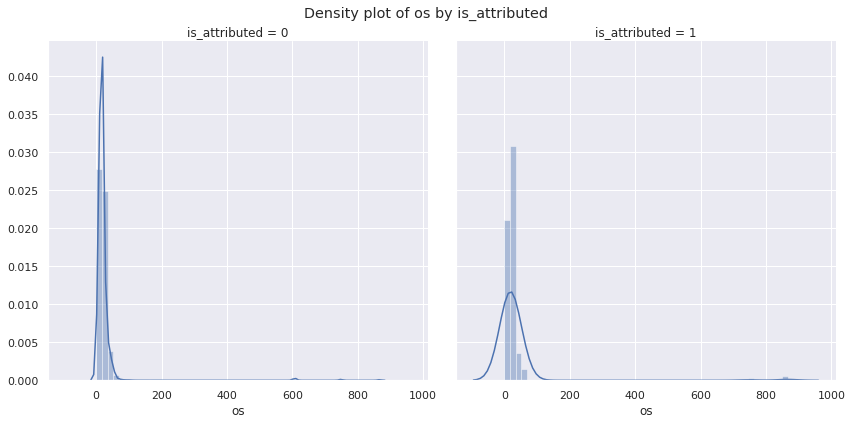

In [0]:
create_facet(sample, 'os')

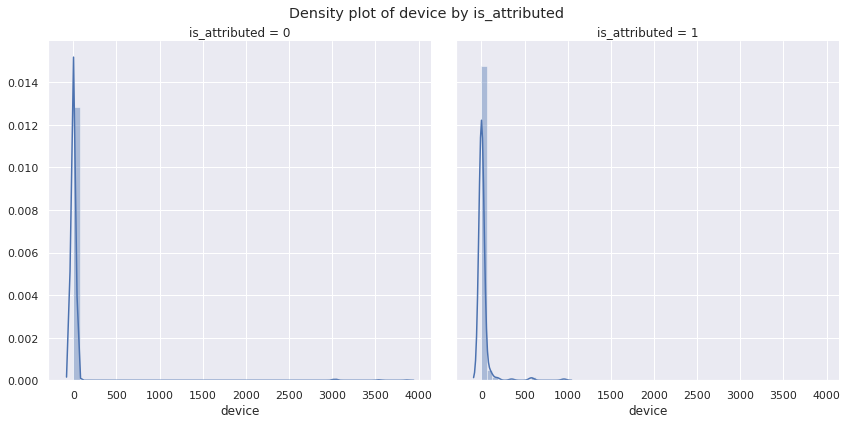

In [0]:
create_facet(sample, 'device')

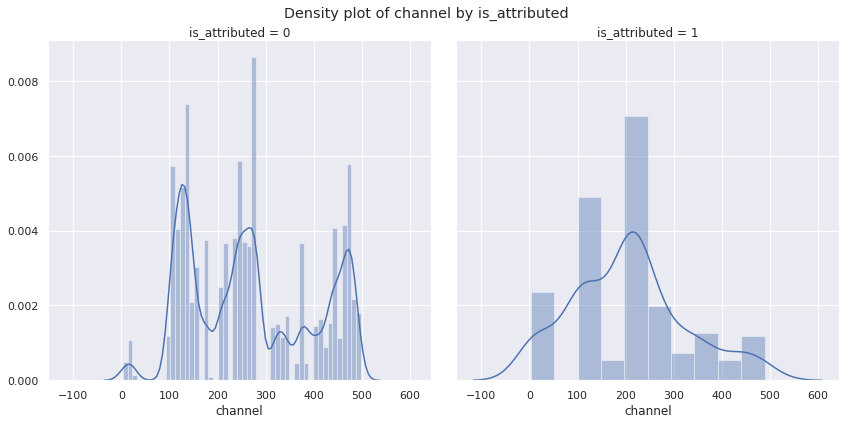

In [0]:
create_facet(sample, 'channel')

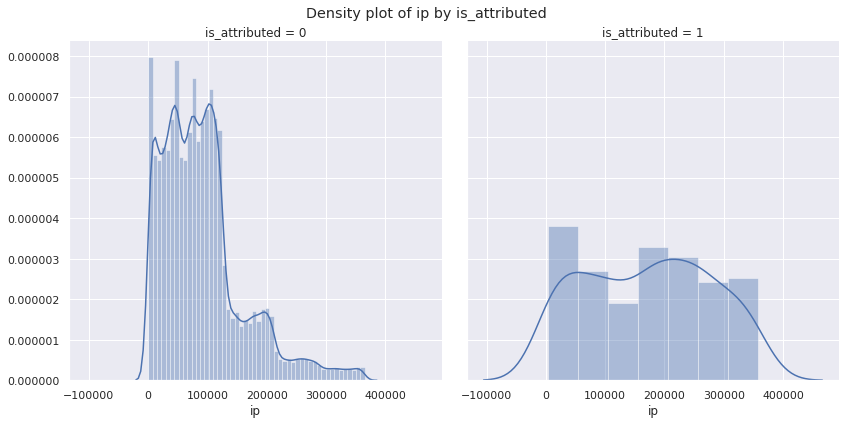

In [0]:
create_facet(sample, 'ip')

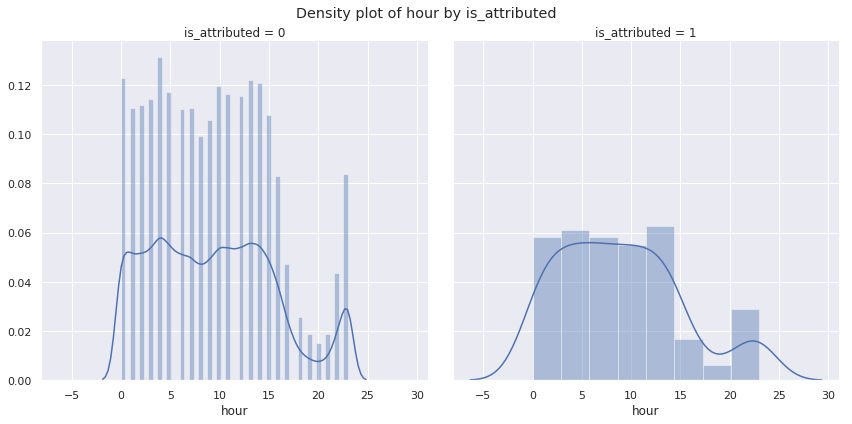

In [0]:
create_facet(sample, 'hour')

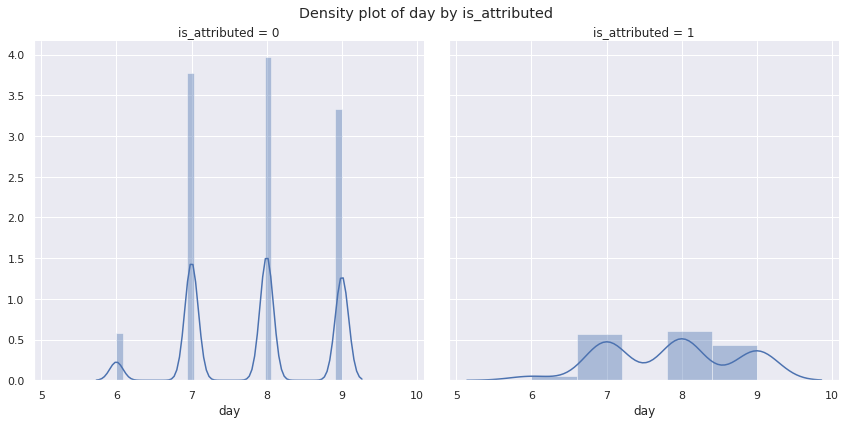

In [0]:
create_facet(sample, 'day')

I'm not seeing anything super interesting when looking at the density plots of each feature by the outcome variable... I want to look at the top 10 most common features for each category

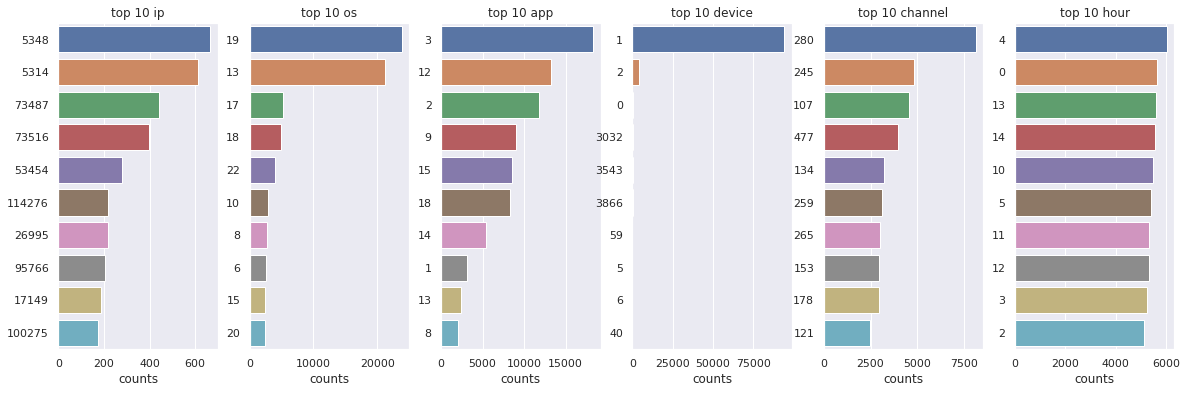

In [0]:
def get_top_10(data, var, i):
  top_10=data[var].value_counts().reset_index(name='counts').sort_values(by='counts', ascending=False).head(10)
  top_10['index']=top_10['index'].astype('category')
  ax=sns.barplot(x='counts', y=top_10.index.astype('category'), data=top_10, ax=i)
  ax.set_yticklabels(top_10['index'])
  ax.set_title('top 10 '+ var)

features = ['ip', 'os', 'app', 'device', 'channel', 'hour']
fig, axs = plt.subplots(1, 6, figsize=(20, 6))

for i, feature in enumerate(features):
  get_top_10(sample[sample['is_attributed']==0], feature, axs[i])
  

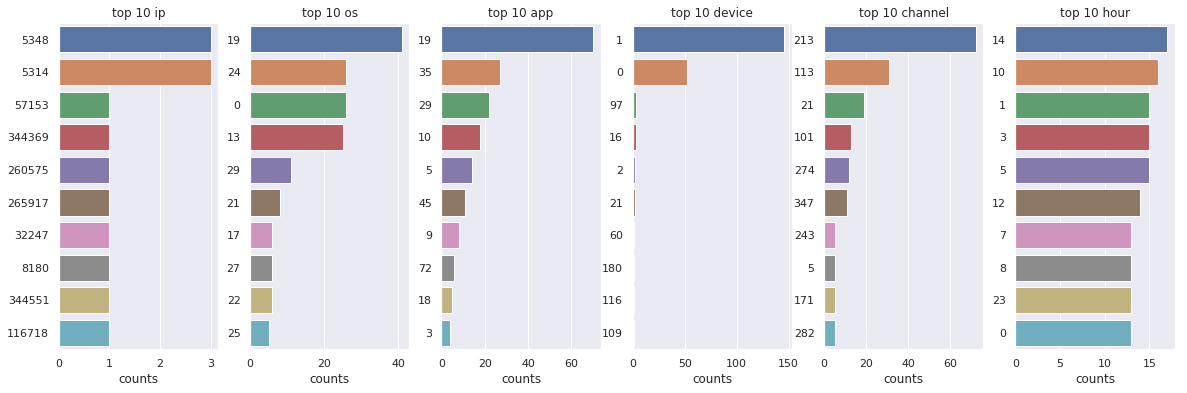

In [0]:
fig, axs = plt.subplots(1, 6, figsize=(20, 6))

for i, feature in enumerate(features):
  get_top_10(sample[sample['is_attributed']==1], feature, axs[i])